<a href="https://colab.research.google.com/github/fcalderonfigueroa/land_microsegregation_lima/blob/main/barriers_collection_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residential Microsegregation in Lima

## Barriers Data Collection

This notebook outlines the process of collecting the barriers data from OpenStreetMap (OSM). I show what the process does [for one block of the city](https://colab.research.google.com/drive/1GsCX3zuWLKmXG0hskO-2ENVFmrJwi2af#scrollTo=kbU0lbbJLSTz) and, then, [for a 300-block sample](https://colab.research.google.com/drive/1GsCX3zuWLKmXG0hskO-2ENVFmrJwi2af#scrollTo=2Jro1C4i9Qtw). Since the operations are computationally intensive, I collected the full dataset using the [Digital Research Alliance of Canada's](https://alliancecan.ca/en) supercomputers.

My goal was to get the count of barriers to mobility (barriers, walls, and fences) at a 1 km distance from each city block *with socioeconomic data* in Lima, Peru (*N*=99,684). I obtained the socioeconomic data from the Peruvian [National Statistics and Informatics Institute (INEI)](https://www.arcgis.com/home/item.html?id=a929c02371f24525a881155ec39cfe68).

I preprocessed the blocks data using the `sf` package in `R`. Thus, here I import the centroids as a `GPKG` file. The final product is another `GPKG` file with two additional attributes: (1) the count of barriers within 1 km network distance using the OSMNx network, and (2) network metrics associated to each block. The former requires spatial operations to properly identify the barriers that interrupt the network connectivity in public spaces. Thus, I created buffers around the networks (at 1, 3, 5, and 10 metres) to capture barriers that overlap with the streets at different widths. For the latter attribute, I obtained the circuity average (`circuity_avg`) and the count of intersections (`intersection_count`), which are authomatically calculated by the `osmnx` package. I index each data point in the loop using `iloc`. The process in the loop is the following:

1. Create the network for the city, including consolidating intersections.
1. Pull a GeoDataFrame or GeoSeries of barriers for the entire city using the `geometries_from_place` function. This single object will be used for the spatial joins with the truncated networks later.
1. Truncate the street network for any given block centroid (rowwise) at the 1 km network distance. This is a two-step process:
 1. Identify the nearest node to the centroid in the network using `osmnx.nearest_nodes`. Save both the node ID and distance from the centroid.
 1. Use the `truncate.truncate_graph_dist` function. Use the node ID from the previous step as the `source_node` argument.
1. Create several buffers around each truncated network. I need to define the buffer levels in metres. For now, I am using buffers at 1, 3, 5, and 10 metres.
1. Perform the spatial join between the barriers GeoDataFrame and the networks for each block at different buffer levels. Keep in mind that the spatial join is performed using the `within` predicate to make sure the barrier falls entirely within the network at any given buffer level.
3. The next and final step is to add the count of barriers and network metrics and add them as attibutes (columns) to the original geopandas GeoDataFrame object and store it as a geopackage.

## Loading Packages and Data

Note that the cell below must be run twice as it will ask to restart the session.

In [7]:
!pip install -U matplotlib
!pip install contextily
!pip install osmnx

In [8]:
import geopandas as gpd
import osmnx as ox
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import numpy as np
import pandas as pd
os.getcwd()

'/content'

In [4]:
# Loading the data from local drive
from google.colab import files
uploaded = files.upload()
# Navigate to the file blocks_centroids_limametro.gpkg

Saving block_centroids_limametro.gpkg to block_centroids_limametro (1).gpkg


In [11]:
df = gpd.read_file(io.BytesIO(uploaded['block_centroids_limametro.gpkg']))

In [12]:
# Exploring the file
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Count of blocks
len(df)

99685

In [13]:
# Inspecting a subset of blocks
df.tail(5)

,OBJECTID_1,DISTRITO,NSE_PREDOM,HIGH_SES,geometry
99680,120629.0,CHORRILLOS,B,0.500000,POINT (-77.01778 -12.20490)
99681,120630.0,CHORRILLOS,C,0.000000,POINT (-77.01863 -12.20431)
99682,120631.0,CHORRILLOS,D,0.323077,POINT (-77.01744 -12.20393)
99683,120632.0,CHORRILLOS,B,0.551724,POINT (-77.01817 -12.20398)
99684,120633.0,CHORRILLOS,A,0.769231,POINT (-77.02316 -12.20128)


CPU times: user 1.27 s, sys: 90.3 ms, total: 1.36 s
Wall time: 3.34 s


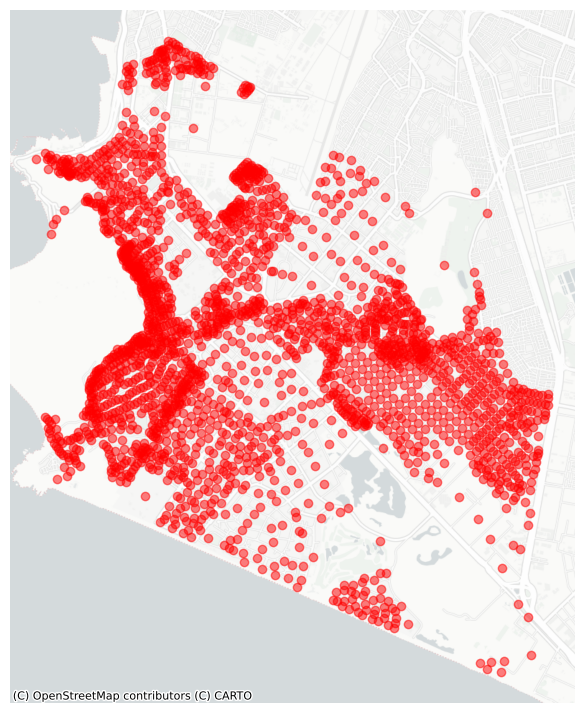

In [34]:
# Plotting
%%time
distrito = df['DISTRITO']=='CHORRILLOS'
df_plot = df[distrito].to_crs(epsg=3857)
f, ax = plt.subplots(1, figsize = (9,9))
df_plot.plot(ax = ax, alpha = 0.5, color = 'red')
ctx.add_basemap(ax, source = ctx.providers.CartoDB.PositronNoLabels)
ax.set_axis_off()

## Example Using One Block in the City

In [35]:
%%time
# Creating network for the entire city
db = ox.graph_from_place('Lima Metropolitana', network_type='walk')

CPU times: user 3min 20s, sys: 5.1 s, total: 3min 25s
Wall time: 3min 46s


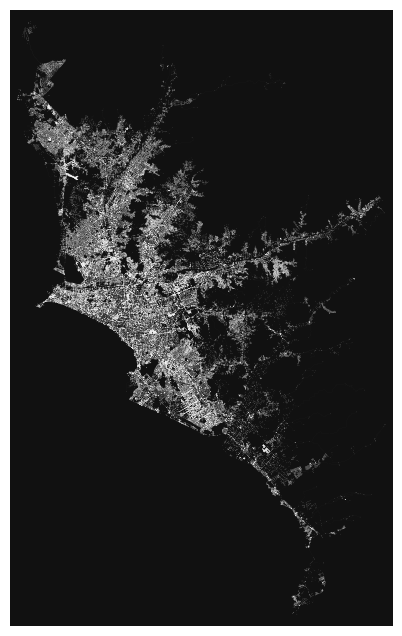

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [36]:
# Plotting the entire network
ox.plot_graph(db, node_size=0.05, edge_linewidth=0.005)

In [37]:
%%time
# Nearest node to block centroid - last row
node = ox.nearest_nodes(db, df.geometry.x.iloc[len(df)-1], df.geometry.y.iloc[len(df)-1], return_dist=True)
node

CPU times: user 2.85 s, sys: 9.97 ms, total: 2.86 s
Wall time: 2.9 s


(1287179531, 17.195112944049132)

The distance above (about 17.2) indicates that the node is not too far from the point, which means the operation worked. We can plot the node in context for confirmation.

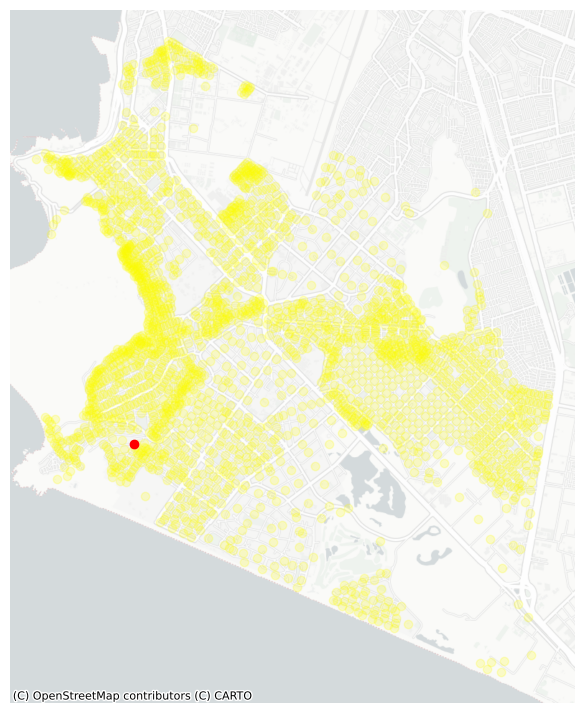

In [38]:
# Plotting node in context
## node
from shapely.geometry import Point
coords = {'geometry': [Point(db.nodes[node[0]]['x'], db.nodes[node[0]]['y'])]}
pi = gpd.GeoDataFrame(coords, crs='EPSG:4326') # same as network graph
pi_plot = pi.to_crs(epsg=3857)
## blocks
distrito = df['DISTRITO']=='CHORRILLOS'
df_plot = df[distrito].to_crs(epsg=3857)
## plot
f, ax = plt.subplots(1, figsize = (9,9))
df_plot.plot(ax = ax, alpha = 0.2, color = 'yellow')
pi_plot.plot(ax = ax, color = 'red')
ctx.add_basemap(ax, source = ctx.providers.CartoDB.PositronNoLabels)
ax.set_axis_off()

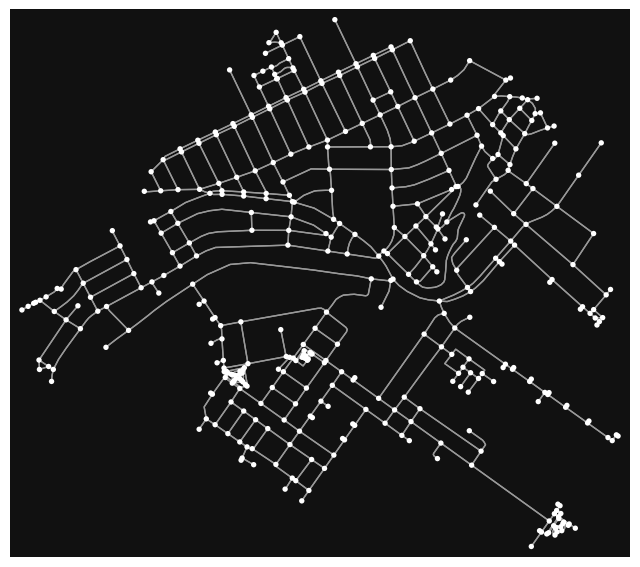

CPU times: user 11.7 s, sys: 129 ms, total: 11.9 s
Wall time: 12.4 s


(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [39]:
%%time
# Network for nearest node
db_trunc = ox.truncate.truncate_graph_dist(db, node[0], max_dist=1000)
ox.plot_graph(db_trunc)

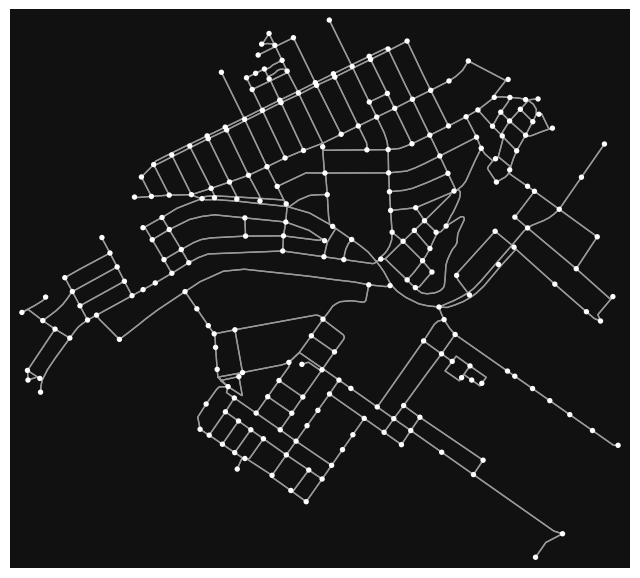

CPU times: user 705 ms, sys: 87.1 ms, total: 792 ms
Wall time: 682 ms


(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [41]:
%%time
# Consolidating intersections
db_proj = ox.project_graph(db_trunc)
db_cons = ox.consolidate_intersections(db_proj, tolerance=10)
ox.plot_graph(db_cons)

Next, we can get the basic stats for this network.

In [42]:
# Getting the network stats
basic_stats = ox.basic_stats(db_cons)
print('circuity average:', basic_stats['circuity_avg'])
print('intersection count:', basic_stats['intersection_count'])

circuity average: 1.0446942667753816
intersection count: 203


Note that this process produces a different network and associated metrics than what we would get building a unique network around each block. Below, the unique network seems to cover a larger area, therefore resulting in higher counts for intersections and, most likely, barriers. I chose the first process for compoutational efficiency.

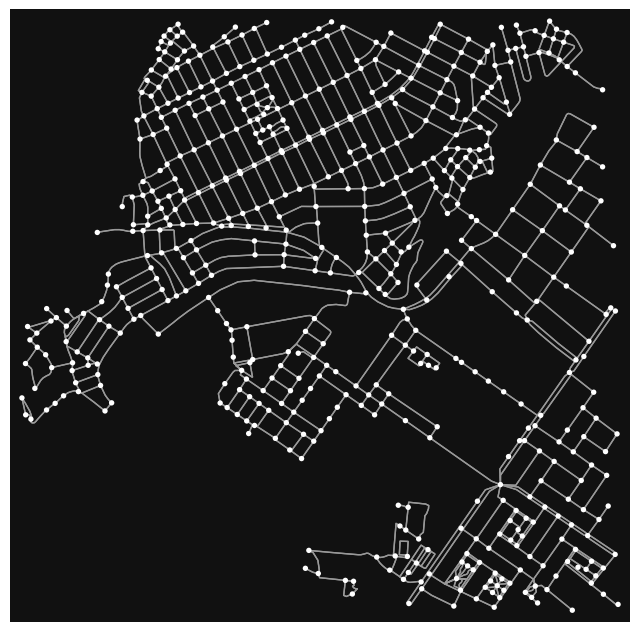

circuity average: 1.0635190089727211
intersection count: 453


In [43]:
# Building network from point for comparison
example_coords = (df.geometry.y.iloc[len(df)-1], df.geometry.x.iloc[len(df)-1])
G = ox.graph_from_point(example_coords, dist=1000, network_type='walk')
G = ox.project_graph(G)
G = ox.consolidate_intersections(G, tolerance=10)
ox.plot_graph(G)
# Betting the network stats
basic_stats_G = ox.basic_stats(G)
print('circuity average:', basic_stats_G['circuity_avg'])
print('intersection count:', basic_stats_G['intersection_count'])

## Integrated Process for 300 blocks
Using a sample, the code:

1. Loads the raw database.
2. Creates the new variables.
3. Samples the data frame for the test.
4. Builds network for city.
5. Pulls the barriers data for the city.
6. Creates the loop. Inside, it:
 1. Identifies nearest node to each block centroid.
 2. Truncates the city's network using the node's id.
 3. Performs the spatial join.
 4. Creates a nested loop for the different buffer levels beyond the original network.
 5. Adds the resulting counts to their corresponding columns (created in Step 2)
7. Stores the resulting GeoDataFrame.

In [ ]:
%%time
df = gpd.read_file(io.BytesIO(uploaded['block_centroids_limametro.gpkg'])) # select the correct df
df['circuity_avg'] = 0
df['intersection_count'] = 0
df['barriers_buff0'] = 0
df['barriers_buff1'] = 0
df['barriers_buff3'] = 0
df['barriers_buff5'] = 0
df['barriers_buff10'] = 0
df['dist_node'] = 0
df_sample = df.sample(n=300, random_state=1).copy() # sample size and seed
db = ox.graph_from_place('Lima Metropolitana, Peru', network_type='walk')
barriers = ox.geometries_from_place('Lima Metropolitana, Peru', tags = {'barrier':True})
for id, row in df_sample.iterrows():
  try:
    node = ox.nearest_nodes(db, row.geometry.x, row.geometry.y, return_dist=True)
    db_trunc = ox.truncate.truncate_graph_dist(db, node[0], max_dist=1000)
    db_proj = ox.project_graph(db_trunc)
    db_cons = ox.consolidate_intersections(db_proj, tolerance=10)
    basic_stats = ox.basic_stats(db_cons)
    # network without buffers
    network0gdf = ox.graph_to_gdfs(db_cons, nodes=False, edges=True,
                               node_geometry=False,
                               fill_edge_geometry=False)
    network4326 = network0gdf.to_crs(epsg=4326)
    barriers0 = barriers.sjoin(network4326, predicate = 'within')
    # for networks with different buffer levels
    buffers = [1,3,5,10]
    barrier_count_buffer = pd.Series(index=buffers, dtype='float64') # series to fill
    for j in buffers:
    # process for each network
      network_buffer = network0gdf.buffer(j)
      # buffer from GeoSeries to GeoDataFrame
      buffer_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(network_buffer)).to_crs(epsg=4326)
      # spatial join using `within`
      barriers_buffer = barriers.sjoin(buffer_gdf, predicate = 'within')
      barrier_count_buffer.loc[j] = len(barriers_buffer)
    df_sample.loc[id, 'circuity_avg'] = basic_stats['circuity_avg']
    df_sample.loc[id, 'intersection_count'] = basic_stats['intersection_count']
    df_sample.loc[id, 'barriers_buff0'] = len(barriers0)
    df_sample.loc[id, 'barriers_buff1'] = barrier_count_buffer[1]
    df_sample.loc[id, 'barriers_buff3'] = barrier_count_buffer[3]
    df_sample.loc[id, 'barriers_buff5'] = barrier_count_buffer[5]
    df_sample.loc[id, 'barriers_buff10'] = barrier_count_buffer[10]
    df_sample.loc[id, 'dist_node'] = node[1]
  except:
    pass

CPU times: user 1h 39min 15s, sys: 52.1 s, total: 1h 40min 7s
Wall time: 1h 40min 47s


In [ ]:
df_sample.head(10)

,OBJECTID_1,DISTRITO,NSE_PREDOM,HIGH_SES,geometry,circuity_avg,intersection_count,barriers_buff0,barriers_buff1,barriers_buff3,barriers_buff5,barriers_buff10,dist_node
89041,97762.0,SAN BORJA,B,1.000000,POINT (-76.98928 -12.08478),1.074826,158,20,56,58,62,110,34.403791
16188,17558.0,SAN JUAN DE LURIGANCHO,C,0.000000,POINT (-77.01396 -11.96766),1.055170,227,0,6,6,6,10,8.835943
90945,99702.0,SAN BORJA,B,0.608696,POINT (-77.00371 -12.09027),1.060585,267,8,28,46,50,80,32.652126
52782,58922.0,CARABAYLLO,D,0.000000,POINT (-77.01237 -11.85517),1.042186,264,2,6,6,6,12,67.940293
73241,80188.0,VILLA MARIA DEL TRIUNFO,C,0.000000,POINT (-76.95757 -12.16350),1.093870,284,38,86,88,100,264,22.992649
55238,61665.0,COMAS,C,0.000000,POINT (-77.05028 -11.95214),1.039148,283,0,0,0,0,0,68.286752
385,337.0,CALLAO,C,0.000000,POINT (-77.12942 -12.02468),1.060489,164,0,0,0,0,0,17.703145
94210,103542.0,ANCON,D,0.000000,POINT (-77.17291 -11.77996),1.050192,164,2,2,2,2,4,24.663910
85405,93631.0,CHORRILLOS,D,0.000000,POINT (-76.99084 -12.19731),1.017124,204,4,4,4,4,4,58.071814
22794,24548.0,SAN JUAN DE LURIGANCHO,D,0.000000,POINT (-77.01467 -12.02134),1.303153,137,2,20,32,48,76,86.018438


In [ ]:
# Writing file to local disk
df_sample.to_file('blocks_buffers_300.gpkg', driver='GPKG')
files.download('blocks_buffers_300.gpkg')